In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Loading the Dataset

In [8]:
# Load the dataset
file_path = '/content/Online Retail.xlsx'
data = pd.read_excel(file_path)
data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#Data Preprocessing

In [12]:
# Remove rows with negative or zero quantities and unit prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Create a 'TotalPrice' column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Grouping by 'CustomerID' to calculate RFM (Recency, Frequency, Monetary)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'     # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

("\nRFM Table:")
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


# Data Normalization

In [14]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

("\nScaled RFM Values:")
(rfm_scaled[:5])

array([[ 2.33457414, -0.3965777 ,  8.35866818],
       [-0.90534032,  0.39464896,  0.25096626],
       [-0.17535959, -0.26543516, -0.02859601],
       [-0.73534481, -0.08183561, -0.0330118 ],
       [ 2.17457836, -0.32663501, -0.19134727]])

#Finding the Optimal Value of K (Elbow Method)

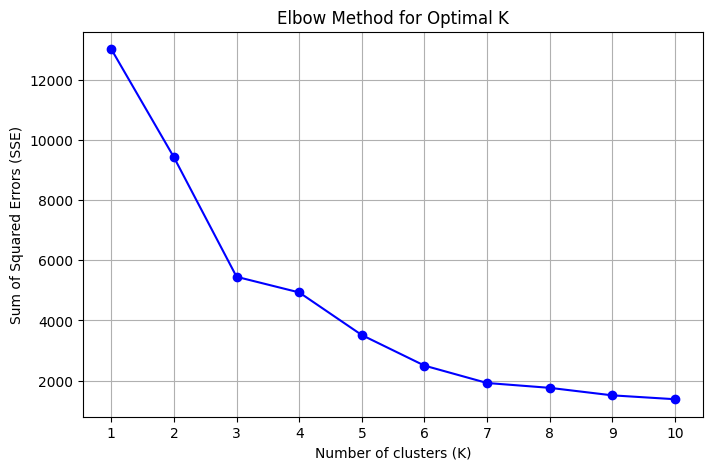

In [15]:
# Elbow method to determine the optimal number of clusters
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

#Applying K-Means Clustering

In [18]:
# Choose the optimal K (based on the Elbow method)
optimal_k = 4  # Adjust based on the Elbow plot

# Applying KMeans with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("\nCluster Centers:")
print(kmeans.cluster_centers_)
print("\nCluster Labels:")
print(rfm['Cluster'].value_counts())


Cluster Centers:
[[-0.71398486  0.18827517  0.06458548]
 [ 0.06278761 -0.23638981 -0.14235053]
 [-0.87841795 10.81308313 13.80299977]
 [ 1.80075046 -0.29114503 -0.16113293]]

Cluster Labels:
Cluster
0    2171
1    1326
3     828
2      13
Name: count, dtype: int64


# Analyzing Clusters

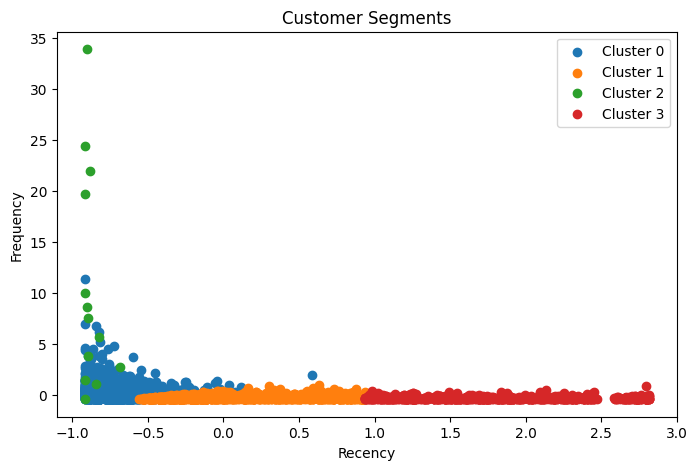

In [19]:
# Visualizing the clusters
plt.figure(figsize=(8, 5))
for cluster in range(optimal_k):
    plt.scatter(rfm_scaled[rfm['Cluster'] == cluster, 0], rfm_scaled[rfm['Cluster'] == cluster, 1], label=f'Cluster {cluster}')

plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()